In [1]:
# Copyright 2019 The Authors. All Rights Reserved.
#
# GNU General Public License v3.0
# Permissions of this strongest copyleft license are conditioned on 
# making available complete source code of licensed works and modifications, 
# which include larger works using a licensed work, under the same license. 
# Copyright and license notices must be preserved. 
# Contributors provide an express grant of patent rights. 
# When a modified version is used to provide a service over a network, 
# the complete source code of the modified version must be made available.
# ==============================================================================

# Title: Clustering of CRISPR repeats using Autoencoders
# Author: Hyunjin Shim
# Date created: 20200207
# Email: jinenstar@gmail.com

# Clustering CRISPR repeats using Autoencoders

- to analyze CRISPR repeats from CRISPR-Cas++
- to cluster CRISPR repeats by type
- to perform dimensionality reduction to identify patterns
- to visualize the results after each experimentation
- to assess the best possible network architecture

# Dataset description
- Archaea: 16,122 repeats
- Bacteria 70,000 repeats
- Classified: repeats classified by Type from CRISPR-Cas++

# Step 1: Load and preprocess raw data

In [2]:
def reproduce(seed_number):
    import tensorflow as tf
    import random
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_number)
    random.seed(seed_number)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    #from keras import backend as K
    tf.set_random_seed(seed_number)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    tf.keras.backend.set_session(sess)

In [3]:
# Data
import os
import pandas as pd
import numpy as np

# Biopython
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

# Regular expression
import re

# Plot
from pylab import *
import pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches

# Tensorflow
import tensorflow as tf
from keras.layers import Input, Dense, Masking
from keras.models import Model
from keras.optimizers import Adam, SGD
from tensorflow.keras import layers

# sklearn
from sklearn.model_selection import train_test_split

reproduce(10)

Using TensorFlow backend.


In [16]:
# location of raw data file
datapath = '/Users/jinenstar/Desktop/Data/CRISPR/CRISPR-Cas++/Class'
os.chdir(datapath)

# use Biopython to process and parse sequences
file_in ='20190618_dr_34.fasta'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ppv_spacer = []
    all_sequence_ppv_spacer = []
    all_length_ppv_spacer = []
    all_des_ppv_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_des_ppv_spacer.append(seq_record.description)
        all_ID_ppv_spacer.append(seq_record.id)
        all_sequence_ppv_spacer.append(seq_record.seq)
        all_length_ppv_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ppv_spacer = max(all_length_ppv_spacer)
min_length_ppv_spacer = min(all_length_ppv_spacer)

In [17]:
print(seq_record)

ID: CP021121.1
Name: CP021121.1
Description: CP021121.1
Number of features: 0
Seq('GCCGTCATCCACCCTGGAGGGTTCGCAAC', SingleLetterAlphabet())


In [18]:
print(min_length_ppv_spacer)
print(all_length_ppv_spacer.index(min_length_ppv_spacer))

23
32


In [19]:
print(max_length_ppv_spacer)
print(all_length_ppv_spacer.index(max_length_ppv_spacer))

50
7351


In [20]:
all_ID_ppv_spacer[-10:]

['CP018961.1|CP027156.1',
 'CP022584.1',
 'CP026860.1',
 'CP023012.1|CP023014.1',
 'CP024588.1',
 'CP003642.1',
 'CP001339.1',
 'CP019967.1|CP002292.1|CP002418.1',
 'CP000681.1',
 'CP021121.1']

In [21]:
all_sequence_ppv_spacer[-10:]

[Seq('GTCGATACCCCCACATGCTGGGGGAATAC', SingleLetterAlphabet()),
 Seq('GTCGCACTCCGTATGGAGTGCGTGGACTGAAAT', SingleLetterAlphabet()),
 Seq('GTTCACCATCGTGTAGATGTCGTGTAGA', SingleLetterAlphabet()),
 Seq('AGTGTTCCCGCGTATGCGGGGATGAACCG', SingleLetterAlphabet()),
 Seq('GTTTCGATCCACGCTCCCGCACGGGGAGCGAG', SingleLetterAlphabet()),
 Seq('GTTACAATTCACCCAAATCCCTCTCAGGGATTGAAAC', SingleLetterAlphabet()),
 Seq('GTCCCTACCCGGGAAGCCGTTAAGGCTGTTGAAACC', SingleLetterAlphabet()),
 Seq('GTTTCGATCCACGCTCCCGCGCGGGGAGCGAC', SingleLetterAlphabet()),
 Seq('GTTCACCGCCGCACGGGCGGCTTAGAAA', SingleLetterAlphabet()),
 Seq('GCCGTCATCCACCCTGGAGGGTTCGCAAC', SingleLetterAlphabet())]

In [22]:
# use Biopython to process and parse sequences
file_in ='Cas1.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_Cas1_spacer = []
    all_sequence_Cas1_spacer = []
    all_length_Cas1_spacer = []
    all_des_Cas1_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_Cas1_spacer.append(seq_record.description)
        all_ID_Cas1_spacer.append(seq_record.id)
        all_sequence_Cas1_spacer.append(seq_record.seq)
        all_length_Cas1_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_Cas1_spacer = max(all_length_Cas1_spacer)
min_length_Cas1_spacer = min(all_length_Cas1_spacer)

print(sum(all_length_Cas1_spacer)/len(all_length_Cas1_spacer))

30.08695652173913


In [23]:
# use Biopython to process and parse sequences
file_in ='orphan.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_orphan_spacer = []
    all_sequence_orphan_spacer = []
    all_length_orphan_spacer = []
    all_des_orphan_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_orphan_spacer.append(seq_record.description)
        all_ID_orphan_spacer.append(seq_record.id)
        all_sequence_orphan_spacer.append(seq_record.seq)
        all_length_orphan_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_orphan_spacer = max(all_length_orphan_spacer)
min_length_orphan_spacer = min(all_length_orphan_spacer)

print(sum(all_length_orphan_spacer)/len(all_length_orphan_spacer))

29.55983070411697


In [24]:
# use Biopython to process and parse sequences
file_in ='TypeIA.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IA_spacer = []
    all_sequence_IA_spacer = []
    all_length_IA_spacer = []
    all_des_IA_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IA_spacer.append(seq_record.description)
        all_ID_IA_spacer.append(seq_record.id)
        all_sequence_IA_spacer.append(seq_record.seq)
        all_length_IA_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IA_spacer = max(all_length_IA_spacer)
min_length_IA_spacer = min(all_length_IA_spacer)

print(sum(all_length_IA_spacer)/len(all_length_IA_spacer))

29.09090909090909


In [25]:
# use Biopython to process and parse sequences
file_in ='TypeIB.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IB_spacer = []
    all_sequence_IB_spacer = []
    all_length_IB_spacer = []
    all_des_IB_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IB_spacer.append(seq_record.description)
        all_ID_IB_spacer.append(seq_record.id)
        all_sequence_IB_spacer.append(seq_record.seq)
        all_length_IB_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IB_spacer = max(all_length_IB_spacer)
min_length_IB_spacer = min(all_length_IB_spacer)

print(sum(all_length_IB_spacer)/len(all_length_IB_spacer))

30.665384615384614


In [26]:
# use Biopython to process and parse sequences
file_in ='TypeIC.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IC_spacer = []
    all_sequence_IC_spacer = []
    all_length_IC_spacer = []
    all_des_IC_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IC_spacer.append(seq_record.description)
        all_ID_IC_spacer.append(seq_record.id)
        all_sequence_IC_spacer.append(seq_record.seq)
        all_length_IC_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IC_spacer = max(all_length_IC_spacer)
min_length_IC_spacer = min(all_length_IC_spacer)

print(sum(all_length_IC_spacer)/len(all_length_IC_spacer))

32.327913279132794


In [27]:
# use Biopython to process and parse sequences
file_in ='TypeID.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ID_spacer = []
    all_sequence_ID_spacer = []
    all_length_ID_spacer = []
    all_des_ID_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_ID_spacer.append(seq_record.description)
        all_ID_ID_spacer.append(seq_record.id)
        all_sequence_ID_spacer.append(seq_record.seq)
        all_length_ID_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ID_spacer = max(all_length_ID_spacer)
min_length_ID_spacer = min(all_length_ID_spacer)

print(sum(all_length_ID_spacer)/len(all_length_ID_spacer))

37.333333333333336


In [28]:
# use Biopython to process and parse sequences
file_in ='TypeIE.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IE_spacer = []
    all_sequence_IE_spacer = []
    all_length_IE_spacer = []
    all_des_IE_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IE_spacer.append(seq_record.description)
        all_ID_IE_spacer.append(seq_record.id)
        all_sequence_IE_spacer.append(seq_record.seq)
        all_length_IE_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IE_spacer = max(all_length_IE_spacer)
min_length_IE_spacer = min(all_length_IE_spacer)

print(sum(all_length_IE_spacer)/len(all_length_IE_spacer))

28.816706443914082


In [29]:
# use Biopython to process and parse sequences
file_in ='TypeIF.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IF_spacer = []
    all_sequence_IF_spacer = []
    all_length_IF_spacer = []
    all_des_IF_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IF_spacer.append(seq_record.description)
        all_ID_IF_spacer.append(seq_record.id)
        all_sequence_IF_spacer.append(seq_record.seq)
        all_length_IF_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IF_spacer = max(all_length_IF_spacer)
min_length_IF_spacer = min(all_length_IF_spacer)

print(sum(all_length_IF_spacer)/len(all_length_IF_spacer))

28.00184842883549


In [30]:
# use Biopython to process and parse sequences
file_in ='TypeIIA.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIA_spacer = []
    all_sequence_IIA_spacer = []
    all_length_IIA_spacer = []
    all_des_IIA_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIA_spacer.append(seq_record.description)
        all_ID_IIA_spacer.append(seq_record.id)
        all_sequence_IIA_spacer.append(seq_record.seq)
        all_length_IIA_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIA_spacer = max(all_length_IIA_spacer)
min_length_IIA_spacer = min(all_length_IIA_spacer)

print(sum(all_length_IIA_spacer)/len(all_length_IIA_spacer))

35.71869328493648


In [31]:
# use Biopython to process and parse sequences
file_in ='TypeIIB.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIB_spacer = []
    all_sequence_IIB_spacer = []
    all_length_IIB_spacer = []
    all_des_IIB_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIB_spacer.append(seq_record.description)
        all_ID_IIB_spacer.append(seq_record.id)
        all_sequence_IIB_spacer.append(seq_record.seq)
        all_length_IIB_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIB_spacer = max(all_length_IIB_spacer)
min_length_IIB_spacer = min(all_length_IIB_spacer)

print(sum(all_length_IIB_spacer)/len(all_length_IIB_spacer))

36.96078431372549


In [32]:
# use Biopython to process and parse sequences
file_in ='TypeIIC.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIC_spacer = []
    all_sequence_IIC_spacer = []
    all_length_IIC_spacer = []
    all_des_IIC_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIC_spacer.append(seq_record.description)
        all_ID_IIC_spacer.append(seq_record.id)
        all_sequence_IIC_spacer.append(seq_record.seq)
        all_length_IIC_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIC_spacer = max(all_length_IIC_spacer)
min_length_IIC_spacer = min(all_length_IIC_spacer)

print(sum(all_length_IIC_spacer)/len(all_length_IIC_spacer))

38.51478494623656


In [33]:
# use Biopython to process and parse sequences
file_in ='TypeIIIA.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIIA_spacer = []
    all_sequence_IIIA_spacer = []
    all_length_IIIA_spacer = []
    all_des_IIIA_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIIA_spacer.append(seq_record.description)
        all_ID_IIIA_spacer.append(seq_record.id)
        all_sequence_IIIA_spacer.append(seq_record.seq)
        all_length_IIIA_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIIA_spacer = max(all_length_IIIA_spacer)
min_length_IIIA_spacer = min(all_length_IIIA_spacer)

print(sum(all_length_IIIA_spacer)/len(all_length_IIIA_spacer))

35.43157894736842


In [34]:
# use Biopython to process and parse sequences
file_in ='TypeIIIB.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIIB_spacer = []
    all_sequence_IIIB_spacer = []
    all_length_IIIB_spacer = []
    all_des_IIIB_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIIB_spacer.append(seq_record.description)
        all_ID_IIIB_spacer.append(seq_record.id)
        all_sequence_IIIB_spacer.append(seq_record.seq)
        all_length_IIIB_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIIB_spacer = max(all_length_IIIB_spacer)
min_length_IIIB_spacer = min(all_length_IIIB_spacer)

print(sum(all_length_IIIB_spacer)/len(all_length_IIIB_spacer))

33.94871794871795


In [35]:
# use Biopython to process and parse sequences
file_in ='TypeIIIC.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIIC_spacer = []
    all_sequence_IIIC_spacer = []
    all_length_IIIC_spacer = []
    all_des_IIIC_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIIC_spacer.append(seq_record.description)
        all_ID_IIIC_spacer.append(seq_record.id)
        all_sequence_IIIC_spacer.append(seq_record.seq)
        all_length_IIIC_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIIC_spacer = max(all_length_IIIC_spacer)
min_length_IIIC_spacer = min(all_length_IIIC_spacer)

print(sum(all_length_IIIC_spacer)/len(all_length_IIIC_spacer))

33.0


In [36]:
# use Biopython to process and parse sequences
file_in ='TypeIIID.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IIID_spacer = []
    all_sequence_IIID_spacer = []
    all_length_IIID_spacer = []
    all_des_IIID_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IIID_spacer.append(seq_record.description)
        all_ID_IIID_spacer.append(seq_record.id)
        all_sequence_IIID_spacer.append(seq_record.seq)
        all_length_IIID_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IIID_spacer = max(all_length_IIID_spacer)
min_length_IIID_spacer = min(all_length_IIID_spacer)

print(sum(all_length_IIID_spacer)/len(all_length_IIID_spacer))

33.470588235294116


In [37]:
# use Biopython to process and parse sequences
file_in ='TypeIU.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IU_spacer = []
    all_sequence_IU_spacer = []
    all_length_IU_spacer = []
    all_des_IU_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IU_spacer.append(seq_record.description)
        all_ID_IU_spacer.append(seq_record.id)
        all_sequence_IU_spacer.append(seq_record.seq)
        all_length_IU_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IU_spacer = max(all_length_IU_spacer)
min_length_IU_spacer = min(all_length_IU_spacer)

print(sum(all_length_IU_spacer)/len(all_length_IU_spacer))

36.12621359223301


In [38]:
# use Biopython to process and parse sequences
file_in ='TypeIV.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_IV_spacer = []
    all_sequence_IV_spacer = []
    all_length_IV_spacer = []
    all_des_IV_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_IV_spacer.append(seq_record.description)
        all_ID_IV_spacer.append(seq_record.id)
        all_sequence_IV_spacer.append(seq_record.seq)
        all_length_IV_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_IV_spacer = max(all_length_IV_spacer)
min_length_IV_spacer = min(all_length_IV_spacer)

print(sum(all_length_IV_spacer)/len(all_length_IV_spacer))

29.0


In [39]:
# use Biopython to process and parse sequences
file_in ='TypeVA.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_VA_spacer = []
    all_sequence_VA_spacer = []
    all_length_VA_spacer = []
    all_des_VA_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_VA_spacer.append(seq_record.description)
        all_ID_VA_spacer.append(seq_record.id)
        all_sequence_VA_spacer.append(seq_record.seq)
        all_length_VA_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_VA_spacer = max(all_length_VA_spacer)
min_length_VA_spacer = min(all_length_VA_spacer)

print(sum(all_length_VA_spacer)/len(all_length_VA_spacer))

36.1


In [40]:
# use Biopython to process and parse sequences
file_in ='TypeVIB1.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_VIB1_spacer = []
    all_sequence_VIB1_spacer = []
    all_length_VIB1_spacer = []
    all_des_VIB1_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_VIB1_spacer.append(seq_record.description)
        all_ID_VIB1_spacer.append(seq_record.id)
        all_sequence_VIB1_spacer.append(seq_record.seq)
        all_length_VIB1_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_VIB1_spacer = max(all_length_VIB1_spacer)
min_length_VIB1_spacer = min(all_length_VIB1_spacer)

print(sum(all_length_VIB1_spacer)/len(all_length_VIB1_spacer))

36.285714285714285


In [41]:
# use Biopython to process and parse sequences
file_in ='TypeVIB2.fa'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_VIB2_spacer = []
    all_sequence_VIB2_spacer = []
    all_length_VIB2_spacer = []
    all_des_VIB2_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        all_des_VIB2_spacer.append(seq_record.description)
        all_ID_VIB2_spacer.append(seq_record.id)
        all_sequence_VIB2_spacer.append(seq_record.seq)
        all_length_VIB2_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_VIB2_spacer = max(all_length_VIB2_spacer)
min_length_VIB2_spacer = min(all_length_VIB2_spacer)

print(sum(all_length_VIB2_spacer)/len(all_length_VIB2_spacer))

47.0


In [42]:
# all_ID_I_spacer = all_ID_IA_spacer + all_ID_IB_spacer + all_ID_IC_spacer + all_ID_ID_spacer + all_ID_IE_spacer + all_ID_IF_spacer + all_ID_IU_spacer
# all_sequence_I_spacer = all_sequence_IA_spacer + all_sequence_IB_spacer + all_sequence_IC_spacer + all_sequence_ID_spacer + all_sequence_IE_spacer + all_sequence_IF_spacer + all_sequence_IU_spacer
# all_length_I_spacer = all_length_IA_spacer + all_length_IB_spacer + all_length_IC_spacer + all_length_ID_spacer + all_length_IE_spacer + all_length_IF_spacer + all_length_IU_spacer
# all_des_I_spacer = all_des_IA_spacer + all_des_IB_spacer + all_des_IC_spacer + all_des_ID_spacer + all_des_IE_spacer + all_des_IF_spacer + all_des_IU_spacer

In [43]:
# all_ID_II_spacer = all_ID_IIA_spacer + all_ID_IIB_spacer + all_ID_IIC_spacer
# all_sequence_II_spacer = all_sequence_IIA_spacer + all_sequence_IIB_spacer + all_sequence_IIC_spacer
# all_length_II_spacer = all_length_IIA_spacer + all_length_IIB_spacer + all_length_IIC_spacer
# all_des_II_spacer = all_des_IIA_spacer + all_des_IIB_spacer + all_des_IIC_spacer

In [44]:
# all_ID_III_spacer = all_ID_IIIA_spacer + all_ID_IIIB_spacer + all_ID_IIIC_spacer + all_ID_IIID_spacer
# all_sequence_III_spacer = all_sequence_IIIA_spacer + all_sequence_IIIB_spacer + all_sequence_IIIC_spacer + all_sequence_IIID_spacer
# all_length_III_spacer = all_length_IIIA_spacer + all_length_IIIB_spacer + all_length_IIIC_spacer + all_length_IIID_spacer
# all_des_III_spacer = all_des_IIIA_spacer + all_des_IIIB_spacer + all_des_IIIC_spacer + all_des_IIID_spacer

In [45]:
all_ID_ex_spacer = all_ID_IV_spacer + all_ID_VA_spacer + all_ID_VIB1_spacer + all_ID_VIB2_spacer
all_sequence_ex_spacer = all_sequence_IV_spacer + all_sequence_VA_spacer + all_sequence_VIB1_spacer + all_sequence_VIB2_spacer
all_length_ex_spacer = all_length_IV_spacer + all_length_VA_spacer + all_length_VIB1_spacer + all_length_VIB2_spacer
all_des_ex_spacer = all_des_IV_spacer + all_des_VA_spacer + all_des_VIB1_spacer + all_des_VIB2_spacer

In [46]:
# print(sum(all_length_I_spacer)/len(all_length_I_spacer))
# print(sum(all_length_II_spacer)/len(all_length_II_spacer))
# print(sum(all_length_III_spacer)/len(all_length_III_spacer))
print(sum(all_length_ex_spacer)/len(all_length_ex_spacer))

35.23809523809524


In [47]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ppv_spacer = []
for i in range(len(all_sequence_ppv_spacer)):
    all_sequence_no_ppv_spacer.append(str(all_sequence_ppv_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [48]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_Cas1_spacer = []
for i in range(len(all_sequence_Cas1_spacer)):
    all_sequence_no_Cas1_spacer.append(str(all_sequence_Cas1_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [49]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_orphan_spacer = []
for i in range(len(all_sequence_orphan_spacer)):
    all_sequence_no_orphan_spacer.append(str(all_sequence_orphan_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('B','0').replace('H','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [50]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IA_spacer = []
for i in range(len(all_sequence_IA_spacer)):
    all_sequence_no_IA_spacer.append(str(all_sequence_IA_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('B','0').replace('H','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [51]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IB_spacer = []
for i in range(len(all_sequence_IB_spacer)):
    all_sequence_no_IB_spacer.append(str(all_sequence_IB_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [52]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IC_spacer = []
for i in range(len(all_sequence_IC_spacer)):
    all_sequence_no_IC_spacer.append(str(all_sequence_IC_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [53]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ID_spacer = []
for i in range(len(all_sequence_ID_spacer)):
    all_sequence_no_ID_spacer.append(str(all_sequence_ID_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [54]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IE_spacer = []
for i in range(len(all_sequence_IE_spacer)):
    all_sequence_no_IE_spacer.append(str(all_sequence_IE_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [55]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IF_spacer = []
for i in range(len(all_sequence_IF_spacer)):
    all_sequence_no_IF_spacer.append(str(all_sequence_IF_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [56]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIA_spacer = []
for i in range(len(all_sequence_IIA_spacer)):
    all_sequence_no_IIA_spacer.append(str(all_sequence_IIA_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [57]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIB_spacer = []
for i in range(len(all_sequence_IIB_spacer)):
    all_sequence_no_IIB_spacer.append(str(all_sequence_IIB_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [58]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIC_spacer = []
for i in range(len(all_sequence_IIC_spacer)):
    all_sequence_no_IIC_spacer.append(str(all_sequence_IIC_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [59]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIIA_spacer = []
for i in range(len(all_sequence_IIIA_spacer)):
    all_sequence_no_IIIA_spacer.append(str(all_sequence_IIIA_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [60]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIIB_spacer = []
for i in range(len(all_sequence_IIIB_spacer)):
    all_sequence_no_IIIB_spacer.append(str(all_sequence_IIIB_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [61]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIIC_spacer = []
for i in range(len(all_sequence_IIIC_spacer)):
    all_sequence_no_IIIC_spacer.append(str(all_sequence_IIIC_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [62]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_IIID_spacer = []
for i in range(len(all_sequence_IIID_spacer)):
    all_sequence_no_IIID_spacer.append(str(all_sequence_IIID_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [63]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ex_spacer = []
for i in range(len(all_sequence_ex_spacer)):
    all_sequence_no_ex_spacer.append(str(all_sequence_ex_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('.','').replace('(','').replace(')',''))

In [64]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_Cas1_spacer)):
    T = T+all_sequence_no_Cas1_spacer[i].count('1')
    A = A+all_sequence_no_Cas1_spacer[i].count('2')
    G = G+all_sequence_no_Cas1_spacer[i].count('3')
    C = C+all_sequence_no_Cas1_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_Cas1_spacer))

0.7149938042131351
30.08695652173913


In [65]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_orphan_spacer)):
    T = T+all_sequence_no_orphan_spacer[i].count('1')
    A = A+all_sequence_no_orphan_spacer[i].count('2')
    G = G+all_sequence_no_orphan_spacer[i].count('3')
    C = C+all_sequence_no_orphan_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_orphan_spacer))

1.0833152527663268
29.555983070411695


In [66]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_ppv_spacer)):
    T = T+all_sequence_no_ppv_spacer[i].count('1')
    A = A+all_sequence_no_ppv_spacer[i].count('2')
    G = G+all_sequence_no_ppv_spacer[i].count('3')
    C = C+all_sequence_no_ppv_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_ppv_spacer))

1.0629281346606927
31.3604368303918


In [67]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IA_spacer)):
    T = T+all_sequence_no_IA_spacer[i].count('1')
    A = A+all_sequence_no_IA_spacer[i].count('2')
    G = G+all_sequence_no_IA_spacer[i].count('3')
    C = C+all_sequence_no_IA_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IA_spacer))

0.5023474178403756
29.09090909090909


In [68]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IB_spacer)):
    T = T+all_sequence_no_IB_spacer[i].count('1')
    A = A+all_sequence_no_IB_spacer[i].count('2')
    G = G+all_sequence_no_IB_spacer[i].count('3')
    C = C+all_sequence_no_IB_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IB_spacer))

0.45652173913043476
30.665384615384614


In [69]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IC_spacer)):
    T = T+all_sequence_no_IC_spacer[i].count('1')
    A = A+all_sequence_no_IC_spacer[i].count('2')
    G = G+all_sequence_no_IC_spacer[i].count('3')
    C = C+all_sequence_no_IC_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IC_spacer))

1.473356831847398
32.327913279132794


In [70]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_ID_spacer)):
    T = T+all_sequence_no_ID_spacer[i].count('1')
    A = A+all_sequence_no_ID_spacer[i].count('2')
    G = G+all_sequence_no_ID_spacer[i].count('3')
    C = C+all_sequence_no_ID_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_ID_spacer))

0.5774647887323944
37.333333333333336


In [71]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IE_spacer)):
    T = T+all_sequence_no_IE_spacer[i].count('1')
    A = A+all_sequence_no_IE_spacer[i].count('2')
    G = G+all_sequence_no_IE_spacer[i].count('3')
    C = C+all_sequence_no_IE_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IE_spacer))

2.0232383432663896
28.813842482100238


In [72]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IF_spacer)):
    T = T+all_sequence_no_IF_spacer[i].count('1')
    A = A+all_sequence_no_IF_spacer[i].count('2')
    G = G+all_sequence_no_IF_spacer[i].count('3')
    C = C+all_sequence_no_IF_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IF_spacer))

0.9327634600663435
28.00184842883549


In [73]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIA_spacer)):
    T = T+all_sequence_no_IIA_spacer[i].count('1')
    A = A+all_sequence_no_IIA_spacer[i].count('2')
    G = G+all_sequence_no_IIA_spacer[i].count('3')
    C = C+all_sequence_no_IIA_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIA_spacer))

0.5577805920531897
35.71869328493648


In [74]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIB_spacer)):
    T = T+all_sequence_no_IIB_spacer[i].count('1')
    A = A+all_sequence_no_IIB_spacer[i].count('2')
    G = G+all_sequence_no_IIB_spacer[i].count('3')
    C = C+all_sequence_no_IIB_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIB_spacer))

0.47959183673469385
36.96078431372549


In [75]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIC_spacer)):
    T = T+all_sequence_no_IIC_spacer[i].count('1')
    A = A+all_sequence_no_IIC_spacer[i].count('2')
    G = G+all_sequence_no_IIC_spacer[i].count('3')
    C = C+all_sequence_no_IIC_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIC_spacer))

0.44812942366026287
38.5


In [76]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIIA_spacer)):
    T = T+all_sequence_no_IIIA_spacer[i].count('1')
    A = A+all_sequence_no_IIIA_spacer[i].count('2')
    G = G+all_sequence_no_IIIA_spacer[i].count('3')
    C = C+all_sequence_no_IIIA_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIIA_spacer))

0.7167778347870702
35.22105263157895


In [77]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIIB_spacer)):
    T = T+all_sequence_no_IIIB_spacer[i].count('1')
    A = A+all_sequence_no_IIIB_spacer[i].count('2')
    G = G+all_sequence_no_IIIB_spacer[i].count('3')
    C = C+all_sequence_no_IIIB_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIIB_spacer))

0.6974358974358974
33.94871794871795


In [78]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIIC_spacer)):
    T = T+all_sequence_no_IIIC_spacer[i].count('1')
    A = A+all_sequence_no_IIIC_spacer[i].count('2')
    G = G+all_sequence_no_IIIC_spacer[i].count('3')
    C = C+all_sequence_no_IIIC_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIIC_spacer))

1.5384615384615385
33.0


In [79]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_IIID_spacer)):
    T = T+all_sequence_no_IIID_spacer[i].count('1')
    A = A+all_sequence_no_IIID_spacer[i].count('2')
    G = G+all_sequence_no_IIID_spacer[i].count('3')
    C = C+all_sequence_no_IIID_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_IIID_spacer))

0.745398773006135
33.470588235294116


In [80]:
T=0
A=0
G=0
C=0
for i in range(len(all_sequence_no_ex_spacer)):
    T = T+all_sequence_no_ex_spacer[i].count('1')
    A = A+all_sequence_no_ex_spacer[i].count('2')
    G = G+all_sequence_no_ex_spacer[i].count('3')
    C = C+all_sequence_no_ex_spacer[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(all_sequence_no_ex_spacer))

0.533678756476684
35.23809523809524


In [81]:
all_sequence_no = all_sequence_no_ppv_spacer + all_sequence_no_Cas1_spacer + all_sequence_no_orphan_spacer + all_sequence_no_IA_spacer + all_sequence_no_IB_spacer + all_sequence_no_IC_spacer + all_sequence_no_ID_spacer + all_sequence_no_IE_spacer + all_sequence_no_IF_spacer + all_sequence_no_IIA_spacer + all_sequence_no_IIB_spacer + all_sequence_no_IIC_spacer + all_sequence_no_IIIA_spacer + all_sequence_no_IIIB_spacer + all_sequence_no_IIIC_spacer + all_sequence_no_IIID_spacer + all_sequence_no_ex_spacer

In [82]:
# dictionary to DataFrame
all_ID = all_ID_ppv_spacer + all_ID_Cas1_spacer + all_ID_orphan_spacer + all_ID_IA_spacer + all_ID_IB_spacer + all_ID_IC_spacer + all_ID_ID_spacer + all_ID_IE_spacer + all_ID_IF_spacer + all_ID_IIA_spacer + all_ID_IIB_spacer + all_ID_IIC_spacer + all_ID_IIIA_spacer + all_ID_IIIB_spacer + all_ID_IIIC_spacer + all_ID_IIID_spacer + all_ID_ex_spacer
all_length = all_length_ppv_spacer + all_length_Cas1_spacer + all_length_orphan_spacer + all_length_IA_spacer + all_length_IB_spacer + all_length_IC_spacer + all_length_ID_spacer + all_length_IE_spacer + all_length_IF_spacer + all_length_IIA_spacer + all_length_IIB_spacer + all_length_IIC_spacer + all_length_IIIA_spacer + all_length_IIIB_spacer + all_length_IIIC_spacer + all_length_IIID_spacer + all_length_ex_spacer

all_label_ppv_spacer = [0] * len(all_sequence_ppv_spacer)
all_label_Cas1_spacer = [1] * len(all_sequence_Cas1_spacer)
all_label_orphan_spacer = [2] * len(all_sequence_orphan_spacer)
all_label_IA_spacer = [3] * len(all_sequence_IA_spacer)
all_label_IB_spacer = [4] * len(all_sequence_IB_spacer)
all_label_IC_spacer = [5] * len(all_sequence_IC_spacer)
all_label_ID_spacer = [6] * len(all_sequence_ID_spacer)
all_label_IE_spacer = [7] * len(all_sequence_IE_spacer)
all_label_IF_spacer = [8] * len(all_sequence_IF_spacer)
all_label_IIA_spacer = [9] * len(all_sequence_IIA_spacer)
all_label_IIB_spacer = [10] * len(all_sequence_IIB_spacer)
all_label_IIC_spacer = [11] * len(all_sequence_IIC_spacer)
all_label_IIIA_spacer = [12] * len(all_sequence_IIIA_spacer)
all_label_IIIB_spacer = [13] * len(all_sequence_IIIB_spacer)
all_label_IIIC_spacer = [14] * len(all_sequence_IIIC_spacer)
all_label_IIID_spacer = [15] * len(all_sequence_IIID_spacer)
all_label_ex_spacer = [16] * len(all_sequence_ex_spacer)
all_label = all_label_ppv_spacer + all_label_Cas1_spacer + all_label_orphan_spacer + all_label_IA_spacer + all_label_IB_spacer + all_label_IC_spacer + all_label_ID_spacer + all_label_IE_spacer + all_label_IF_spacer + all_label_IIA_spacer + all_label_IIB_spacer + all_label_IIC_spacer + all_label_IIIA_spacer + all_label_IIIB_spacer + all_label_IIIC_spacer + all_label_IIID_spacer + all_label_ex_spacer

all_keyword_ppv_spacer = ['Cas++'] * len(all_sequence_ppv_spacer)
all_keyword_Cas1_spacer = ['Cas1'] * len(all_sequence_Cas1_spacer)
all_keyword_orphan_spacer = ['orphan'] * len(all_sequence_orphan_spacer)
all_keyword_IA_spacer = ['Type IA'] * len(all_sequence_IA_spacer)
all_keyword_IB_spacer = ['Type IB'] * len(all_sequence_IB_spacer)
all_keyword_IC_spacer = ['Type IC'] * len(all_sequence_IC_spacer)
all_keyword_ID_spacer = ['Type ID'] * len(all_sequence_ID_spacer)
all_keyword_IE_spacer = ['Type IE'] * len(all_sequence_IE_spacer)
all_keyword_IF_spacer = ['Type IF'] * len(all_sequence_IF_spacer)
all_keyword_IIA_spacer = ['Type IIA'] * len(all_sequence_IIA_spacer)
all_keyword_IIB_spacer = ['Type IIB'] * len(all_sequence_IIB_spacer)
all_keyword_IIC_spacer = ['Type IIC'] * len(all_sequence_IIC_spacer)
all_keyword_IIIA_spacer = ['Type IIIA'] * len(all_sequence_IIIA_spacer)
all_keyword_IIIB_spacer = ['Type IIIB'] * len(all_sequence_IIIB_spacer)
all_keyword_IIIC_spacer = ['Type IIIC'] * len(all_sequence_IIIC_spacer)
all_keyword_IIID_spacer = ['Type IIID'] * len(all_sequence_IIID_spacer)
all_keyword_ex_spacer = ['ex'] * len(all_sequence_ex_spacer)
all_keyword = all_keyword_ppv_spacer + all_keyword_Cas1_spacer + all_keyword_orphan_spacer + all_keyword_IA_spacer + all_keyword_IB_spacer + all_keyword_IC_spacer + all_keyword_ID_spacer + all_keyword_IE_spacer + all_keyword_IF_spacer + all_keyword_IIA_spacer + all_keyword_IIB_spacer + all_keyword_IIC_spacer + all_keyword_IIIA_spacer + all_keyword_IIIB_spacer + all_keyword_IIIC_spacer + all_keyword_IIID_spacer + all_keyword_ex_spacer

d = {'ID':all_ID, 'Category':all_keyword, 'Label':all_label, 'Length':all_length, 'Sequence':all_sequence_no}
all_data = pd.DataFrame(d)

In [83]:
all_data

,ID,Category,Label,Length,Sequence
0,CP022521.1,Cas++,0,30,311334244441441233334321323324
1,CP017986.1|CP018313.1|CP018687.1|CP018714.1,Cas++,0,30,244321224444434242433333322124
2,CP009803.1|CM002272.1|CP029339.1,Cas++,0,28,3143344443424413433233424444
3,LT629804.1|CP002045.1|LS483427.1,Cas++,0,29,23222124444434313134333322323
4,CP022737.1|LN813019.1,Cas++,0,29,42341421444121223434333321433
5,LR026975.1,Cas++,0,36,414343311441143332344341411421132334
6,CP035926.1|CP034309.1|CP035928.1,Cas++,0,36,311112214124141422214444211132121221
7,CP027860.1,Cas++,0,34,3143423434241134434222334421132324
8,CP002952.1|CP008887.1,Cas++,0,30,311342212232414423323221132223
9,CP006577.1,Cas++,0,24,411344311414411213232114


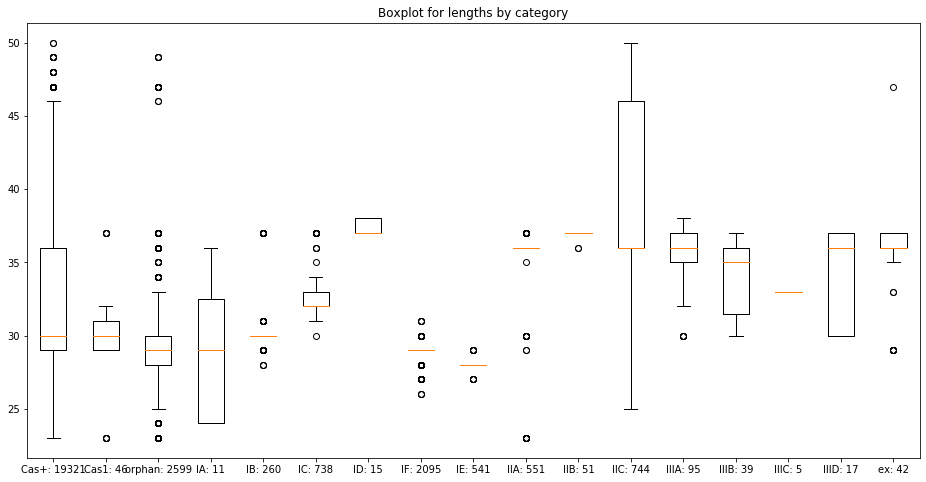

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt

data_ppv = all_data[all_data['Label']==0]
len_ppv = len(data_ppv)
data_Cas1 = all_data[all_data['Label']==1]
len_Cas1 = len(data_Cas1)
data_orphan = all_data[all_data['Label']==2]
len_orphan = len(data_orphan)
data_IA = all_data[all_data['Label']==3]
len_IA = len(data_IA)
data_IB = all_data[all_data['Label']==4]
len_IB = len(data_IB)
data_IC = all_data[all_data['Label']==5]
len_IC = len(data_IC)
data_ID = all_data[all_data['Label']==6]
len_ID = len(data_ID)
data_IE = all_data[all_data['Label']==7]
len_IE = len(data_IE)
data_IF = all_data[all_data['Label']==8]
len_IF = len(data_IF)
data_IIA = all_data[all_data['Label']==9]
len_IIA = len(data_IIA)
data_IIB = all_data[all_data['Label']==10]
len_IIB = len(data_IIB)
data_IIC = all_data[all_data['Label']==11]
len_IIC = len(data_IIC)
data_IIIA = all_data[all_data['Label']==12]
len_IIIA = len(data_IIIA)
data_IIIB = all_data[all_data['Label']==13]
len_IIIB = len(data_IIIB)
data_IIIC = all_data[all_data['Label']==14]
len_IIIC = len(data_IIIC)
data_IIID = all_data[all_data['Label']==15]
len_IIID = len(data_IIID)
data_ex = all_data[all_data['Label']==16]
len_ex = len(data_ex)

# boxplot
data_plot = [data_ppv['Length'],data_Cas1['Length'],data_orphan['Length'],data_IA['Length'],data_IB['Length'],data_IC['Length'],data_ID['Length'],data_IE['Length'],data_IF['Length'],data_IIA['Length'],data_IIB['Length'],data_IIC['Length'],data_IIIA['Length'],data_IIIB['Length'],data_IIIC['Length'],data_IIID['Length'],data_ex['Length']]
fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.set_title('Boxplot for lengths by category')
ax1.boxplot(data_plot)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],['Cas+: '+str(len_ppv),'Cas1: '+str(len_Cas1),'orphan: '+str(len_orphan),'IA: '+str(len_IA),'IB: '+str(len_IB),'IC: '+str(len_IC),'ID: '+str(len_ID),'IF: '+str(len_IE),'IE: '+str(len_IF),'IIA: '+str(len_IIA),'IIB: '+str(len_IIB),'IIC: '+str(len_IIC),'IIIA: '+str(len_IIIA),'IIIB: '+str(len_IIIB),'IIIC: '+str(len_IIIC),'IIID: '+str(len_IIID),'ex: '+str(len_ex)])
plt.show()

In [85]:
# numpy array of sequences of a fixed length
# define dimension of features
no_dim_features = 50
# define numpy array with dimension
all_sequence_no_dim = np.empty(shape=(len(all_sequence_no),no_dim_features))

print(all_sequence_no_dim.shape)

for n in range(len(all_sequence_no)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in str(all_sequence_no[n])]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= no_dim_features:
        all_sequence_no_dim[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim[n]=sequence_digits[0:no_dim_features]   

(27170, 50)


In [86]:
all_sequence_no_dim

array([[3., 1., 1., ..., 0., 0., 0.],
       [2., 4., 4., ..., 0., 0., 0.],
       [3., 1., 4., ..., 0., 0., 0.],
       ...,
       [3., 1., 1., ..., 0., 0., 0.],
       [3., 1., 1., ..., 0., 0., 0.],
       [3., 1., 1., ..., 0., 0., 0.]])

In [87]:
from sklearn.preprocessing import MinMaxScaler
#scale data 0-1
min_max_scaler = MinMaxScaler( feature_range=(0,1), copy=True )
all_sequence_no_dim_norm = min_max_scaler.fit_transform(all_sequence_no_dim)

# Step 2: Create, compile, fit autoencoder model
- use Keras, a high-level neural networks API that runs on top of librares like TensorFlow.

In [90]:
#split the data in training and test sets
Y = pd.Series(all_label)

x_train, x_test, y_train_og, y_test = train_test_split(all_sequence_no_dim_norm, Y, test_size=0.1, random_state=10)
print('Training set has', x_train.shape[0], 'rows and', x_train.shape[1], 'columns')
print('Test set has', x_test.shape[0], 'rows and', x_test.shape[1], 'columns')

Training set has 24453 rows and 50 columns
Test set has 2717 rows and 50 columns


In [91]:
y_train = pd.Series(y_train_og).values

In [254]:
#plot original data, reconstructed data, residuals
def plot_reconstruction(data_norm, data_dec):
    plt.figure(figsize=(30,20))
    plt.subplot(3,1,1)
    cmap = cm.get_cmap('PuRd', 5)
    
    ax1 = plt.imshow(data_norm, cmap=cmap, aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0:NA', '0.25:T', '0.5:A', '0.75:G', '1:C'])
    plt.title('Original data', fontsize=25)
    plt.subplot(3,1,2)
    
    ax2 = plt.imshow(data_dec, cmap=cmap, aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0:NA', '0.25:T', '0.5:A', '0.75:G', '1:C'])
    plt.title('Recondstruction', fontsize=25)
    plt.subplot(3,1,3)
    
    ax3 = plt.imshow(data_norm-data_dec, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
#    plt.gca().set_xticks(range(no_dim_features))
#    plt.gca().set_xticklabels(markers, fontsize=20)
    cbar = plt.colorbar(ax3)
#    cbar = plt.colorbar(ticks=range(0,1),label='Group')

    plt.title('Residuals', fontsize=25)
    plt.show()
    # print residual values
    print(sum(abs(data_norm-data_dec)))
    
#plot training history
def plot_history(autoencoder):
    fig = plt.figure(figsize=(6,4))
    plt.plot(autoencoder.history.history['loss'])
    plt.plot(autoencoder.history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss function')
    plt.legend(['Loss', 'Validation loss'])
    plt.show()

In [93]:
#set dimensions of input and hidden layer
input_dim = no_dim_features
# intermediate_1 = int(input_dim/2)
# intermediate_2 = int(intermediate_1/2)
# intermediate_3 = int(intermediate_2/2)
latent_dim = 2

# Keras API default: weight=glorot_uniform, bias=zeros optimizer=SGD
input_data = Input(shape=(input_dim,))
input_data_masked = Masking(mask_value=0)(input_data)

#encode the input with a dense layer
#encoded_1 = Dense(latent_dim, activation='relu')(input_data)
encoded_1 = Dense(latent_dim, activation='relu')(input_data_masked)
# encoded_2 = Dense(intermediate_2, activation='sigmoid')(encoded_1)
# encoded_3 = Dense(intermediate_3, activation='sigmoid')(encoded_2)
# encoded_4 = Dense(latent_dim, activation='sigmoid')(encoded_3)

#decode the encoded input to its reconstruction
# decoded_1 = Dense(intermediate_3, activation='sigmoid')(encoded_4)
# decoded_2 = Dense(intermediate_2, activation='sigmoid')(decoded_1)
# decoded_3 = Dense(intermediate_1, activation='sigmoid')(decoded_2)
decoded_1 = Dense(input_dim, activation='sigmoid')(encoded_1)

#autoencoder_2 maps the input to the output
autoencoder_1 = Model(input_data, decoded_1)

#encoder_2 maps the input to the latent representation
encoder_1 = Model(input_data, encoded_1)

#compile the model and set the desired optimizer and loss function
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=True: 197278.616427557 (1000, relu/sigmoid)
#lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False: 198390.04078465368 (1000, relu/sigmoid)
#lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False: 196701.81024503498 (1000, relu/sigmoid)
#lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False: 198119.42320937128
#lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False: 201498.04332982833, 194848.54589565698, 195846.1733820932
#lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False: 203297.8982813275
#lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False: 203880.1092371781
#lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False: 215747.461111864
#lr=0.001, beta_1=0.9, beta_2=0.999: 196275.98964004725
#lr=0.0005, beta_1=0.9, beta_2=0.999: 196425.90351344965
#lr=0.0001, beta_1=0.9, beta_2=0.999: 196708.90596440926
#lr=0.00005, beta_1=0.9, beta_2=0.999: 

# # zero masking
# masking_layer = layers.Masking()
# # Simulate the embedding lookup by expanding the 2D input to 3D, with embedding dimension of 10.
# unmasked_embedding = tf.cast(
#     tf.tile(tf.expand_dims(x_train, axis=-1), [1, 1, 10]),
#     tf.float32)
# masked_embedding = masking_layer(unmasked_embedding)
# print(masked_embedding._keras_mask)

autoencoder_1.compile(optimizer=adam, loss='mean_squared_error')
autoencoder_1.summary()
autoencoder_1.fit(x_train, x_train,
                epochs=1000,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
masking_1 (Masking)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                150       
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 24453 samples, validate on 2717 samples
Epoch 1/1000
24453/24453 [==============================] - 0s 9us/step - loss: 0.1470 - val_loss: 0.1303
E

24453/24453 [==============================] - 0s 3us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 140/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 141/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 142/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 143/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 144/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 145/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 146/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 147/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 148/1000
24453/24453 [===============

Epoch 215/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 216/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 217/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 218/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 219/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 220/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 221/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 222/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 223/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0452 - val_loss: 0.0450
Epoch 224/1000
24453/24453 [

Epoch 291/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 292/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 293/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 294/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 295/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 296/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 297/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 298/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 299/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 300/1000
24453/24453 [

Epoch 367/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 368/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 369/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 370/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 371/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 372/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 373/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 374/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 375/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 376/1000
24453/24453 [

Epoch 443/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 444/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 445/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 446/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 447/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 448/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 449/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 450/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 451/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 452/1000
24453/24453 [

Epoch 519/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 520/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 521/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 522/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 523/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 524/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 525/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 526/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 527/1000
24453/24453 [==============================] - 0s 5us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 528/1000
24453/24453 [

Epoch 595/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 596/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 597/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 598/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 599/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 600/1000
24453/24453 [==============================] - 0s 5us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 601/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 602/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 603/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 604/1000
24453/24453 [

Epoch 671/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 672/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 673/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 674/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 675/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 676/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 677/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 678/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 679/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 680/1000
24453/24453 [

Epoch 747/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 748/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 749/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 750/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 751/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 752/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 753/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 754/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 755/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 756/1000
24453/24453 [

Epoch 823/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 824/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 825/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 826/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 827/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 828/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 829/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 830/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 831/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 832/1000
24453/24453 [

Epoch 899/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 900/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 901/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 902/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 903/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 904/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 905/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 906/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 907/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 908/1000
24453/24453 [

Epoch 975/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 976/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 977/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 978/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 979/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 980/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 981/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 982/1000
24453/24453 [==============================] - 0s 4us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 983/1000
24453/24453 [==============================] - 0s 3us/step - loss: 0.0451 - val_loss: 0.0450
Epoch 984/1000
24453/24453 [

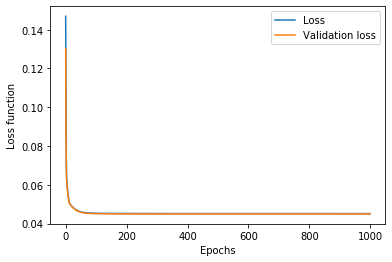

In [94]:
plot_history(autoencoder_1)

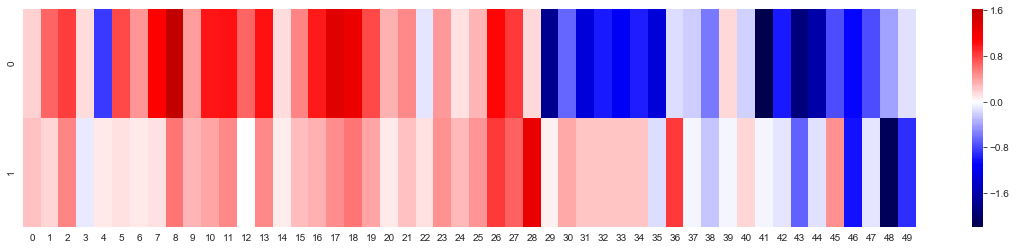

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#get the weights of the hidden layer
weights=autoencoder_1.layers[2].get_weights()
#visualize the weights
plt.figure(figsize=(20,4))
sns.heatmap(data=transpose(weights[0]), cmap='seismic', center=0)
#plt.gca().set_xticklabels(range(no_dim_features))
plt.show()

In [272]:
#plot reduced dimensions
def plot_encoded(x_train_encoded, y_train): 
    ppv_patch = mpatches.Patch(color='yellow', label='All DRs')
    Cas1_patch = mpatches.Patch(color='silver', label='Cas1')
    orphan_patch = mpatches.Patch(color='orange', label='orphan')
    IA_patch = mpatches.Patch(color='lime', label='Type IA')
    IB_patch = mpatches.Patch(color='navy', label='Type IB')
    IC_patch = mpatches.Patch(color='magenta', label='Type IC')
    ID_patch = mpatches.Patch(color='purple', label='Type ID')
    IE_patch = mpatches.Patch(color='olive', label='Type IE')
    IF_patch = mpatches.Patch(color='red', label='Type IF')
    IIA_patch = mpatches.Patch(color='cyan', label='Type IIA')
    IIB_patch = mpatches.Patch(color='blue', label='Type IIB')
    IIC_patch = mpatches.Patch(color='green', label='Type IIC')
    IIIA_patch = mpatches.Patch(color='gray', label='Type IIIA')
    IIIB_patch = mpatches.Patch(color='maroon', label='Type IIIB')
    IIIC_patch = mpatches.Patch(color='black', label='Type IIIC')
    IIID_patch = mpatches.Patch(color='teal', label='Type IIID')
    ex_patch = mpatches.Patch(color='brown', label='ex')

    fig = plt.figure(figsize=(10,8))
    #ax = plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], s=5, c=label_color, alpha=0.05)
    ax = plt.scatter(x_train_encoded[y_train==0,0], x_train_encoded[y_train==0,1], s=5, c='yellow')
    ax = plt.scatter(x_train_encoded[y_train==1,0], x_train_encoded[y_train==1,1], s=5, c='silver')
    ax = plt.scatter(x_train_encoded[y_train==2,0], x_train_encoded[y_train==2,1], s=5, c='orange')
    ax = plt.scatter(x_train_encoded[y_train==3,0], x_train_encoded[y_train==3,1], s=5, c='lime')
    ax = plt.scatter(x_train_encoded[y_train==4,0], x_train_encoded[y_train==4,1], s=5, c='navy')
    ax = plt.scatter(x_train_encoded[y_train==5,0], x_train_encoded[y_train==5,1], s=5, c='magenta')
    ax = plt.scatter(x_train_encoded[y_train==6,0], x_train_encoded[y_train==6,1], s=5, c='purple')
    ax = plt.scatter(x_train_encoded[y_train==7,0], x_train_encoded[y_train==7,1], s=5, c='olive')
    ax = plt.scatter(x_train_encoded[y_train==8,0], x_train_encoded[y_train==8,1], s=5, c='red')
    ax = plt.scatter(x_train_encoded[y_train==9,0], x_train_encoded[y_train==9,1], s=5, c='cyan')
    ax = plt.scatter(x_train_encoded[y_train==10,0], x_train_encoded[y_train==10,1], s=5, c='blue')
    ax = plt.scatter(x_train_encoded[y_train==11,0], x_train_encoded[y_train==11,1], s=5, c='green')
    ax = plt.scatter(x_train_encoded[y_train==12,0], x_train_encoded[y_train==12,1], s=5, c='gray')
    ax = plt.scatter(x_train_encoded[y_train==13,0], x_train_encoded[y_train==13,1], s=5, c='maroon')
    ax = plt.scatter(x_train_encoded[y_train==14,0], x_train_encoded[y_train==14,1], s=5, c='black')
    ax = plt.scatter(x_train_encoded[y_train==15,0], x_train_encoded[y_train==15,1], s=5, c='teal')
    ax = plt.scatter(x_train_encoded[y_train==16,0], x_train_encoded[y_train==16,1], s=5, c='brown')

    #cbar = plt.colorbar(ax, ticks=range(21))
    #cbar.ax.set_yticklabels(cell_types['cell type name'])
    #ax.set_facecolor('white')

    plt.legend(handles=[ppv_patch,Cas1_patch,orphan_patch,IA_patch,IB_patch,IC_patch,ID_patch,IE_patch,IF_patch,IIA_patch,IIB_patch,IIC_patch,IIIA_patch,IIIB_patch,IIIC_patch,IIID_patch,ex_patch],loc='lower right')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()
    fig.savefig('CRISPR_DR_PublicParis_clusterbyCas_2D.pdf')

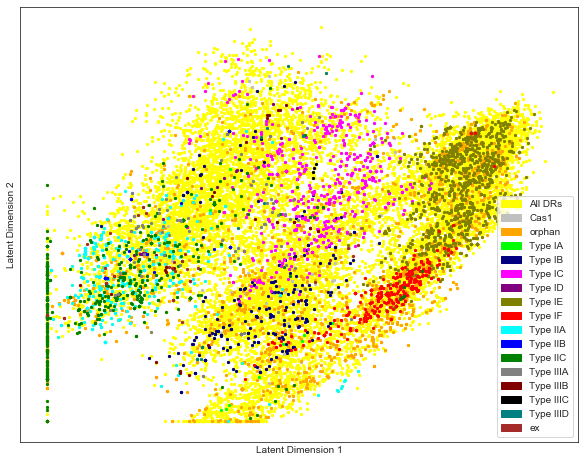

In [273]:
#encoder input into latent dimensions
x_enc_1 = encoder_1.predict(x_train, batch_size=256)
plot_encoded(x_enc_1, y_train)

In [266]:
#plot reduced dimensions
def plot_encoded(x_train_encoded, y_train): 
#    ppv_patch = mpatches.Patch(color='yellow', label='Cas++')
#    Cas1_patch = mpatches.Patch(color='silver', label='Cas1')
    orphan_patch = mpatches.Patch(color='orange', label='orphan')
    IA_patch = mpatches.Patch(color='lime', label='Type IA')
    IB_patch = mpatches.Patch(color='navy', label='Type IB')
    IC_patch = mpatches.Patch(color='magenta', label='Type IC')
    ID_patch = mpatches.Patch(color='purple', label='Type ID')
    IE_patch = mpatches.Patch(color='olive', label='Type IE')
    IF_patch = mpatches.Patch(color='red', label='Type IF')
    IIA_patch = mpatches.Patch(color='cyan', label='Type IIA')
    IIB_patch = mpatches.Patch(color='blue', label='Type IIB')
    IIC_patch = mpatches.Patch(color='green', label='Type IIC')
    IIIA_patch = mpatches.Patch(color='gray', label='Type IIIA')
    IIIB_patch = mpatches.Patch(color='maroon', label='Type IIIB')
    IIIC_patch = mpatches.Patch(color='black', label='Type IIIC')
    IIID_patch = mpatches.Patch(color='teal', label='Type IIID')
    ex_patch = mpatches.Patch(color='brown', label='ex')

    fig = plt.figure(figsize=(10,8))
    #ax = plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], s=5, c=label_color, alpha=0.05)
#    ax = plt.scatter(x_train_encoded[y_train==0,0], x_train_encoded[y_train==0,1], s=5, c='yellow')
#    ax = plt.scatter(x_train_encoded[y_train==1,0], x_train_encoded[y_train==1,1], s=5, c='silver')
    ax = plt.scatter(x_train_encoded[y_train==2,0], x_train_encoded[y_train==2,1], s=10, c='orange')
    ax = plt.scatter(x_train_encoded[y_train==3,0], x_train_encoded[y_train==3,1], s=5, c='lime')
    ax = plt.scatter(x_train_encoded[y_train==4,0], x_train_encoded[y_train==4,1], s=5, c='navy')
    ax = plt.scatter(x_train_encoded[y_train==5,0], x_train_encoded[y_train==5,1], s=5, c='magenta')
    ax = plt.scatter(x_train_encoded[y_train==6,0], x_train_encoded[y_train==6,1], s=5, c='purple')
    ax = plt.scatter(x_train_encoded[y_train==7,0], x_train_encoded[y_train==7,1], s=5, c='olive')
    ax = plt.scatter(x_train_encoded[y_train==8,0], x_train_encoded[y_train==8,1], s=5, c='red')
    ax = plt.scatter(x_train_encoded[y_train==9,0], x_train_encoded[y_train==9,1], s=5, c='cyan')
    ax = plt.scatter(x_train_encoded[y_train==10,0], x_train_encoded[y_train==10,1], s=5, c='blue')
    ax = plt.scatter(x_train_encoded[y_train==11,0], x_train_encoded[y_train==11,1], s=5, c='green')
    ax = plt.scatter(x_train_encoded[y_train==12,0], x_train_encoded[y_train==12,1], s=5, c='gray')
    ax = plt.scatter(x_train_encoded[y_train==13,0], x_train_encoded[y_train==13,1], s=5, c='maroon')
    ax = plt.scatter(x_train_encoded[y_train==14,0], x_train_encoded[y_train==14,1], s=5, c='black')
    ax = plt.scatter(x_train_encoded[y_train==15,0], x_train_encoded[y_train==15,1], s=5, c='teal')
    ax = plt.scatter(x_train_encoded[y_train==16,0], x_train_encoded[y_train==16,1], s=5, c='brown')

    #cbar = plt.colorbar(ax, ticks=range(21))
    #cbar.ax.set_yticklabels(cell_types['cell type name'])
    #ax.set_facecolor('white')

    plt.legend(handles=[orphan_patch,IA_patch,IB_patch,IC_patch,ID_patch,IE_patch,IF_patch,IIA_patch,IIB_patch,IIC_patch,IIIA_patch,IIIB_patch,IIIC_patch,IIID_patch,ex_patch],loc='lower right')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()
    fig.savefig('CRISPR_DR_PublicParis_clusterbyCas_2D_onlyTypes.pdf')

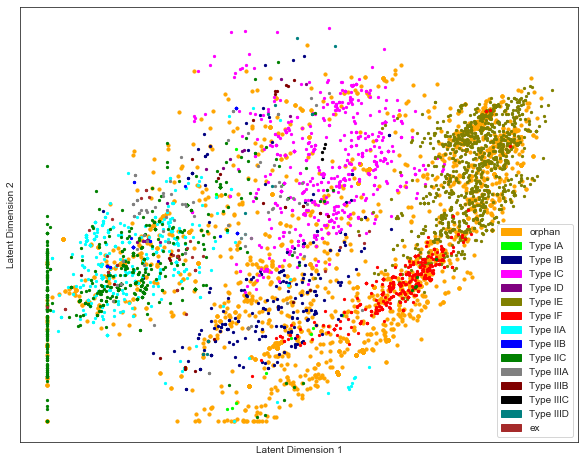

In [267]:
#encoder input into latent dimensions
x_enc_1 = encoder_1.predict(x_train, batch_size=256)
plot_encoded(x_enc_1, y_train)

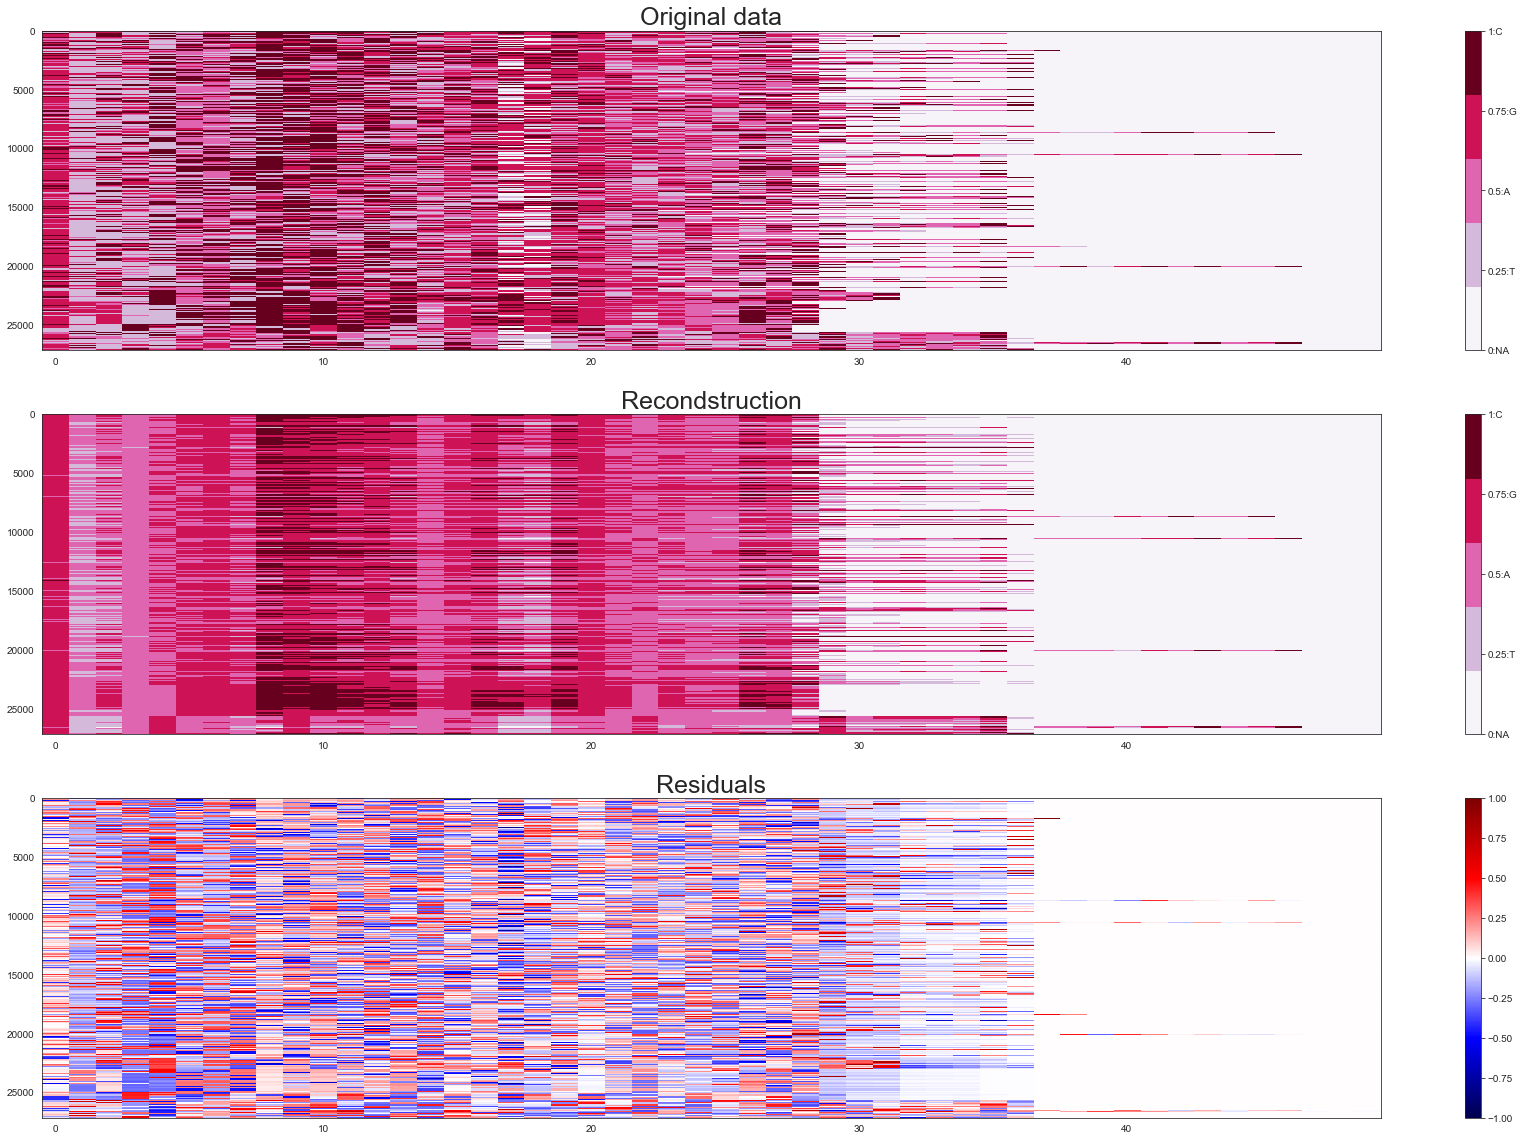

196275.98964004725


In [97]:
#reconstruct the data
data_dec_1 = autoencoder_1.predict(all_sequence_no_dim_norm)
plot_reconstruction(all_sequence_no_dim_norm, data_dec_1)

In [ ]:
# all_des = all_des_ar_spacer + all_des_ba_spacer + all_des_ppv_spacer + all_des_I_spacer + all_des_II_spacer + all_des_III_spacer + all_des_ex_spacer
# all_des[0]
# all_seq = all_sequence_ar_spacer + all_sequence_ba_spacer + all_sequence_ppv_spacer + all_sequence_I_spacer + all_sequence_II_spacer + all_sequence_III_spacer + all_sequence_ex_spacer
# all_seq[0]

In [122]:
from sklearn.cluster import KMeans

n_clusters=7
kmeans = KMeans(n_clusters, random_state=0).fit_predict(x_enc_1)

In [123]:
y_train_index = y_train_og.index.array
d = {'train index':pd.Series(y_train_index),'kmeans':pd.Series(kmeans)}

In [124]:
df = pd.DataFrame(d)

In [126]:
df

,train index,kmeans
0,21765,4
1,3924,0
2,22992,1
3,19145,6
4,22648,6
5,5688,6
6,19119,6
7,6680,4
8,8663,6
9,23583,1


In [ ]:
for n in range(n_clusters):
    cluster = df.loc[df['kmeans']==n]
    res_cluster = [all_ID[i] for i in cluster['train index'].tolist()]
#    res_cluster_seq = [all_seq[i] for i in cluster['train index'].tolist()]
    res_cluster_keyword = [all_keyword[i] for i in cluster['train index'].tolist()]

    with open('Public_ParisCRISPRonly_Classified_repeats_2D-Deep1-Data50-TAG-stat-mask-relu' + str(n) + '.txt', 'w') as f:
        f.write(str(len(res_cluster))+"\n")
#         for item in res_cluster_seq:
#             f.write("%s\n" % item)
        for item in res_cluster:
            f.write("%s\n" % item)
        for item in res_cluster_keyword:
            f.write("%s\n" % item)
#         res_cluster_seq.sort()
#         for item in res_cluster_seq:
#             f.write("%s\n" % item)

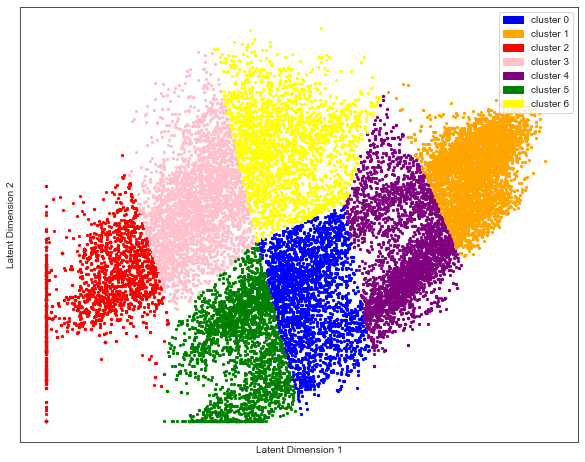

In [127]:
#plot reduced dimensions
def plot_encoded_cluster(x_train_encoded, kmeans): 

    c0_patch = mpatches.Patch(color='blue', label='cluster 0')
    c1_patch = mpatches.Patch(color='orange', label='cluster 1')
    c2_patch = mpatches.Patch(color='red', label='cluster 2')
    c3_patch = mpatches.Patch(color='pink', label='cluster 3')
    c4_patch = mpatches.Patch(color='purple', label='cluster 4')
    c5_patch = mpatches.Patch(color='green', label='cluster 5')
    c6_patch = mpatches.Patch(color='yellow', label='cluster 6')
#    c7_patch = mpatches.Patch(color='black', label='cluster 7')
#    c8_patch = mpatches.Patch(color='grey', label='cluster 8')
#    c9_patch = mpatches.Patch(color='magenta', label='cluster 9')


    fig = plt.figure(figsize=(10,8))
    #ax = plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], s=5, c=label_color, alpha=0.05)
    ax = plt.scatter(x_train_encoded[kmeans==0,0], x_train_encoded[kmeans==0,1], s=5, c='blue')
    ax = plt.scatter(x_train_encoded[kmeans==1,0], x_train_encoded[kmeans==1,1], s=5, c='orange')
    ax = plt.scatter(x_train_encoded[kmeans==2,0], x_train_encoded[kmeans==2,1], s=5, c='red')
    ax = plt.scatter(x_train_encoded[kmeans==3,0], x_train_encoded[kmeans==3,1], s=5, c='pink')
    ax = plt.scatter(x_train_encoded[kmeans==4,0], x_train_encoded[kmeans==4,1], s=5, c='purple')
    ax = plt.scatter(x_train_encoded[kmeans==5,0], x_train_encoded[kmeans==5,1], s=5, c='green')
    ax = plt.scatter(x_train_encoded[kmeans==6,0], x_train_encoded[kmeans==6,1], s=5, c='yellow')
#    ax = plt.scatter(x_train_encoded[kmeans==7,0], x_train_encoded[kmeans==7,1], s=5, c='black')
#    ax = plt.scatter(x_train_encoded[kmeans==8,0], x_train_encoded[kmeans==8,1], s=5, c='grey')
#    ax = plt.scatter(x_train_encoded[kmeans==9,0], x_train_encoded[kmeans==9,1], s=5, c='magenta')
    #     ax = plt.scatter(x_train_encoded[kmeans==5,0], x_train_encoded[kmeans==5,1], s=5, c='yellow')
#     ax = plt.scatter(x_train_encoded[kmeans==6,0], x_train_encoded[kmeans==6,1], s=5, c='black')

    #cbar = plt.colorbar(ax, ticks=range(21))
    #cbar.ax.set_yticklabels(cell_types['cell type name'])
    #ax.set_facecolor('white')

#    plt.legend(handles=[c0_patch,c1_patch,c2_patch,c3_patch,c4_patch,c5_patch,c6_patch,c7_patch,c8_patch,c9_patch],loc='lower right')
    plt.legend(handles=[c0_patch,c1_patch,c2_patch,c3_patch,c4_patch,c5_patch,c6_patch],loc='upper right')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

plot_encoded_cluster(x_enc_1, kmeans)

In [208]:
from sklearn.mixture import GaussianMixture
n_clusters=9
Gmix = GaussianMixture(n_clusters, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10).fit_predict(x_enc_1)

In [209]:
Gmix[:100]

array([4, 0, 8, 0, 0, 3, 3, 4, 3, 8, 1, 6, 8, 7, 4, 7, 5, 8, 5, 1, 7, 1,
       2, 0, 8, 2, 8, 2, 4, 1, 8, 2, 4, 7, 5, 6, 2, 1, 2, 8, 4, 3, 1, 2,
       6, 6, 8, 3, 1, 7, 3, 8, 4, 4, 4, 0, 7, 6, 2, 7, 8, 4, 1, 6, 2, 1,
       1, 8, 5, 8, 2, 8, 4, 2, 7, 7, 0, 7, 8, 2, 7, 4, 8, 3, 2, 1, 5, 6,
       6, 6, 6, 8, 3, 7, 4, 8, 0, 1, 3, 1])

In [210]:
y_train_index = y_train_og.index.array
d = {'train index':pd.Series(y_train_index),'Gmix':pd.Series(Gmix)}

In [211]:
df = pd.DataFrame(d)

In [212]:
df

,train index,Gmix
0,21765,4
1,3924,0
2,22992,8
3,19145,0
4,22648,0
5,5688,3
6,19119,3
7,6680,4
8,8663,3
9,23583,8


In [213]:
for n in range(n_clusters):
    cluster = df.loc[df['Gmix']==n]
    res_cluster = [all_ID[i] for i in cluster['train index'].tolist()]
#    res_cluster_seq = [all_seq[i] for i in cluster['train index'].tolist()]
    res_cluster_keyword = [all_keyword[i] for i in cluster['train index'].tolist()]

    with open('Gmix_Public_ParisCRISPRonly_Classified_repeats_2D-Deep1-Data50-TAG-stat-mask-relu' + str(n) + '.txt', 'w') as f:
        f.write(str(len(res_cluster))+"\n")
#         for item in res_cluster_seq:
#             f.write("%s\n" % item)
        for item in res_cluster:
            f.write("%s\n" % item)
        for item in res_cluster_keyword:
            f.write("%s\n" % item)
#         res_cluster_seq.sort()
#         for item in res_cluster_seq:
#             f.write("%s\n" % item)

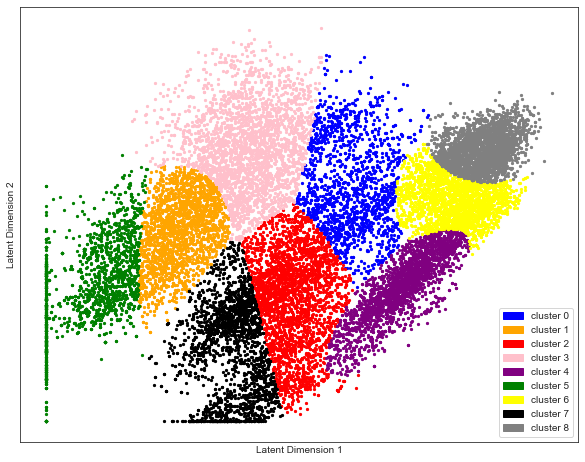

In [215]:
#plot reduced dimensions
def plot_encoded_cluster(x_train_encoded, kmeans): 

    c0_patch = mpatches.Patch(color='blue', label='cluster 0')
    c1_patch = mpatches.Patch(color='orange', label='cluster 1')
    c2_patch = mpatches.Patch(color='red', label='cluster 2')
    c3_patch = mpatches.Patch(color='pink', label='cluster 3')
    c4_patch = mpatches.Patch(color='purple', label='cluster 4')
    c5_patch = mpatches.Patch(color='green', label='cluster 5')
    c6_patch = mpatches.Patch(color='yellow', label='cluster 6')
    c7_patch = mpatches.Patch(color='black', label='cluster 7')
    c8_patch = mpatches.Patch(color='grey', label='cluster 8')
#     c9_patch = mpatches.Patch(color='magenta', label='cluster 9')


    fig = plt.figure(figsize=(10,8))
    #ax = plt.scatter(x_train_encoded[:,0], x_train_encoded[:,1], s=5, c=label_color, alpha=0.05)
    ax = plt.scatter(x_train_encoded[Gmix==0,0], x_train_encoded[kmeans==0,1], s=5, c='blue')
    ax = plt.scatter(x_train_encoded[Gmix==1,0], x_train_encoded[kmeans==1,1], s=5, c='orange')
    ax = plt.scatter(x_train_encoded[Gmix==2,0], x_train_encoded[kmeans==2,1], s=5, c='red')
    ax = plt.scatter(x_train_encoded[Gmix==3,0], x_train_encoded[kmeans==3,1], s=5, c='pink')
    ax = plt.scatter(x_train_encoded[Gmix==4,0], x_train_encoded[kmeans==4,1], s=5, c='purple')
    ax = plt.scatter(x_train_encoded[Gmix==5,0], x_train_encoded[kmeans==5,1], s=5, c='green')
    ax = plt.scatter(x_train_encoded[Gmix==6,0], x_train_encoded[kmeans==6,1], s=5, c='yellow')
    ax = plt.scatter(x_train_encoded[Gmix==7,0], x_train_encoded[kmeans==7,1], s=5, c='black')
    ax = plt.scatter(x_train_encoded[Gmix==8,0], x_train_encoded[kmeans==8,1], s=5, c='grey')
#    ax = plt.scatter(x_train_encoded[Gmix==9,0], x_train_encoded[kmeans==9,1], s=5, c='magenta')
    #     ax = plt.scatter(x_train_encoded[kmeans==5,0], x_train_encoded[kmeans==5,1], s=5, c='yellow')
#     ax = plt.scatter(x_train_encoded[kmeans==6,0], x_train_encoded[kmeans==6,1], s=5, c='black')

    #cbar = plt.colorbar(ax, ticks=range(21))
    #cbar.ax.set_yticklabels(cell_types['cell type name'])
    #ax.set_facecolor('white')

#    plt.legend(handles=[c0_patch,c1_patch,c2_patch,c3_patch,c4_patch,c5_patch,c6_patch,c7_patch,c8_patch,c9_patch],loc='lower right')
    plt.legend(handles=[c0_patch,c1_patch,c2_patch,c3_patch,c4_patch,c5_patch,c6_patch,c7_patch,c8_patch],loc='lower right')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

plot_encoded_cluster(x_enc_1, Gmix)

In [ ]:
cluster0 = df.loc[df['kmeans'] == 0]
cluster1 = df.loc[df['kmeans'] == 1]
cluster2 = df.loc[df['kmeans'] == 2]
cluster3 = df.loc[df['kmeans'] == 3]
cluster4 = df.loc[df['kmeans'] == 4]
cluster5 = df.loc[df['kmeans'] == 5]
cluster6 = df.loc[df['kmeans'] == 6]
cluster7 = df.loc[df['kmeans'] == 7]
# cluster8 = df.loc[df['kmeans'] == 8]
# cluster9 = df.loc[df['kmeans'] == 9]

In [ ]:
from statistics import mean

all_data_Length_list = all_data['Length'].tolist() 
len_cluster0 = [all_data_Length_list[i] for i in cluster0['train index'].tolist()]
len_cluster1 = [all_data_Length_list[i] for i in cluster1['train index'].tolist()]
len_cluster2 = [all_data_Length_list[i] for i in cluster2['train index'].tolist()]
len_cluster3 = [all_data_Length_list[i] for i in cluster3['train index'].tolist()]
len_cluster4 = [all_data_Length_list[i] for i in cluster4['train index'].tolist()]
len_cluster5 = [all_data_Length_list[i] for i in cluster5['train index'].tolist()]
len_cluster6 = [all_data_Length_list[i] for i in cluster6['train index'].tolist()]
len_cluster7 = [all_data_Length_list[i] for i in cluster7['train index'].tolist()]
# len_cluster8 = [all_data_Length_list[i] for i in cluster8['train index'].tolist()]
# len_cluster9 = [all_data_Length_list[i] for i in cluster9['train index'].tolist()]

print(mean(len_cluster0))
print(mean(len_cluster1))
print(mean(len_cluster2))
print(mean(len_cluster3))
print(mean(len_cluster4))

In [ ]:
all_data_Sequence_list = all_data['Sequence'].tolist() 
Seq_cluster0 = [all_data_Sequence_list[i] for i in cluster0['train index'].tolist()]
Seq_cluster1 = [all_data_Sequence_list[i] for i in cluster1['train index'].tolist()]
Seq_cluster2 = [all_data_Sequence_list[i] for i in cluster2['train index'].tolist()]
Seq_cluster3 = [all_data_Sequence_list[i] for i in cluster3['train index'].tolist()]
Seq_cluster4 = [all_data_Sequence_list[i] for i in cluster4['train index'].tolist()]
Seq_cluster5 = [all_data_Sequence_list[i] for i in cluster5['train index'].tolist()]
Seq_cluster6 = [all_data_Sequence_list[i] for i in cluster6['train index'].tolist()]
Seq_cluster7 = [all_data_Sequence_list[i] for i in cluster7['train index'].tolist()]
# Seq_cluster8 = [all_data_Sequence_list[i] for i in cluster8['train index'].tolist()]
# Seq_cluster9 = [all_data_Sequence_list[i] for i in cluster9['train index'].tolist()]

In [ ]:
Seq_cluster0

In [ ]:
Seq_cluster_n=Seq_cluster0
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster1
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster2
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster3
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster4
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster5
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster6
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster7
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster8
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))

In [ ]:
Seq_cluster_n=Seq_cluster9
T=0
A=0
G=0
C=0
for i in range(len(Seq_cluster_n)):
    T = T+Seq_cluster_n[i].count('1')
    A = A+Seq_cluster_n[i].count('2')
    G = G+Seq_cluster_n[i].count('3')
    C = C+Seq_cluster_n[i].count('4')

print((G+C)/(T+A))
print((G+C+T+A)/len(Seq_cluster_n))